# Monitoring coastal erosion along Africa's coastline

* **Products used:**
[ls8_sr](https://explorer.digitalearth.africa/ls8_sr), [ls9_sr](https://explorer.digitalearth.africa/ls9_sr)

## Background
Over 40% of the world’s population lives within 100 km of the coastline. 
However, coastal environments are constantly changing, with erosion and coastal change presenting a major challenge to valuable coastal infrastructure and important ecological habitats. 
Up-to-date data on coastal change and erosion is essential for coastal managers to be able to identify and minimise the impacts of coastal change and erosion.

Monitoring coastlines and rivers using field surveys can be challenging and hazardous, particularly at regional or national scale. 
Aerial photography and LiDAR can be used to monitor coastal change, but this is often expensive and requires many repeated flights over the same areas of coastline to build up an accurate history of how the coastline has changed across time.

### Digital Earth Africa use case
Imagery from satellites such as the NASA/USGS Landsat program is available for free for the entire planet, making satellite imagery a powerful and cost-effective tool for monitoring coastlines and rivers at regional or national scale.
However, the usefulness of satellite imagery in the coastal zone can be affected by the presence of clouds, sun-glint over water, poor water quality (e.g. sediment) and the influence of tides.

The effect of these factors can be reduced by combining individual noisy images into cleaner "summary" or composite layers, and filtering the data to focus only on images taken at certain tidal conditions (e.g. mid-tide). 
These clean, tidally-constrained composite images can then be used to identify and extract the precise boundary between water and land.
This allows us to extract accurate shorelines that can be compared across time to reveal hotspots of erosion and coastal change.

### Description

In this example, we use a simplified version of the [DE Africa Coastlines](https://github.com/digitalearthafrica/deafrica-coastlines.git) method to combine data from the Landsat 8 and 9 satellites with image compositing and tide filtering techniques to accurately map shorelines across time, and identify areas that have changed significantly between 2013 and 2021. 
The worked example demonstrates how to:

1.  Load in a cloud-free Landsat time series
2.  Compute a water index (MNDWI)
3.  Filter images by tide height to discard low and high tide imagery
4.  Create "summary" or composite images for each year of data
5.  Extract and visualise annual shorelines across time
6.  Use these annual shorelines to calculate and visualise rates of coastal change


## Getting started
**To run this analysis**, run all the cells in the notebook, starting with the "Load packages" cell.

**After finishing the analysis**, return to the "Analysis parameters" cell, modify some values (e.g. choose a different location or time period to analyse) and re-run the analysis.
There are additional instructions on modifying the notebook at the end.

### Load packages
First we need to install additional tools from the [DE Africa Coastlines](https://github.com/digitalearthafrica/deafrica-coastlines.git) repository that will allow us to estimate rates of coastal change. 
> **Note:** If you run into any error messages in this analysis, try restarting the notebook by clicking `Kernel`, then `Restart Kernel and Clear All Outputs`.

In [1]:
pip install -q git+https://github.com/digitalearthafrica/deafrica-coastlines.git --disable-pip-version-check

Note: you may need to restart the kernel to use updated packages.


Now we can load key Python packages and supporting functions for the analysis.

In [2]:
%matplotlib inline

# Force GeoPandas to use Shapely instead of PyGEOS
# In a future release, GeoPandas will switch to using Shapely by default.
import os
os.environ['USE_PYGEOS'] = '0'

import datacube
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.ops import nearest_points

from deafrica_tools.datahandling import load_ard, mostcommon_crs
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.coastal import tidal_tag
from deafrica_tools.spatial import subpixel_contours
from deafrica_tools.plotting import display_map, rgb, map_shapefile
from deafrica_tools.dask import create_local_dask_cluster
from coastlines.vector import points_on_line, annual_movements, calculate_regressions

import warnings
warnings.filterwarnings("ignore")

## Set up a Dask cluster

Dask can be used to better manage memory use down and conduct the analysis in parallel. 
For an introduction to using Dask with Digital Earth Africa, see the [Dask notebook](../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

>**Note**: We recommend opening the Dask processing window to view the different computations that are being executed; to do this, see the *Dask dashboard in DE Africa* section of the [Dask notebook](../Beginners_guide/08_parallel_processing_with_dask.ipynb).

To use Dask, set up the local computing cluster using the cell below.

In [ ]:
client = create_local_dask_cluster(return_client=True)

### Connect to the datacube
Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

In [4]:
dc = datacube.Datacube(app="Coastal_erosion")

### Analysis parameters

The following cell set important parameters for the analysis:

* `lat`: The central latitude to analyse (e.g. `14.283`).
* `lon`: The central longitude to analyse (e.g. `-16.921`).
* `buffer`: The number of square degrees to load around the central latitude and longitude. For reasonable loading times, set this as `0.1` or lower.
* `time_range`: The date range to analyse (e.g. `('2013', '2020') `)
* `time_step`: This parameter allows us to choose the length of the time periods we want to compare: e.g. shorelines for each year, or shorelines for each six months etc. 
`1Y` will generate one coastline for every year in the dataset; `6M` will produce a coastline for every six months, etc.
* `tide_range`: The minimum and maximum proportion of the tidal range to include in the analysis. 
For example, `tide_range = (0.50, 1.00)` will select all satellite images taken when the tide was greater than the median (i.e. 50th percentile) of all tide heights and less than the maximum (i.e. 100th percentile) of all tide heights. 
This allows you to seperate the effect of erosion from the influence of tides by producing shorelines for specific tidal conditions (e.g. low tide, average tide, high tide shorelines etc). 

**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.
The example explores coastal change in Ponto, Senegal. 

**To run the notebook for a different area**, make sure Landsat 8 and 9 data is available for the new location, which you can check at the [DE Africa Explorer](https://explorer.digitalearth.africa/) (use the drop-down menu to view all Landsat products).

To ensure that the tidal modelling part of this analysis works correctly, please make sure the **centre of the study area is located over water** when setting `lat_range` and `lon_range`.


In [5]:
# Define the area of interest
lat = 14.29
lon = -16.92
buffer = 0.015

# Combine central lat,lon with buffer to get area of interest
lat_range = (lat - buffer, lat + buffer)
lon_range = (lon - buffer, lon + buffer)

# Set the range of dates for the analysis, time step and tide range
time_range = ('2013', '2021')
time_step = '1Y'
tide_range = (0.25, 0.75)


## View the selected location
The next cell will display the selected area on an interactive map.
Feel free to zoom in and out to get a better understanding of the area you'll be analysing.
Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [6]:
display_map(x=lon_range, y=lat_range)

## Load cloud-masked Landsat data
The first step in this analysis is to load in Landsat data for the `lat_range`, `lon_range` and `time_range` we provided above. 
The code below uses the `load_ard` function to load in data from the Landsat 8 and 9 satellites for the area and time specified.
For more information, see the [Using load_ard notebook](../Frequently_used_code/Using_load_ard.ipynb).
The function will also automatically mask out clouds from the dataset, allowing us to focus on pixels that contain useful data:

In [7]:
# Create the 'query' dictionary object, which contains the longitudes, 
# latitudes and time provided above
query = {
    'x': lon_range,
    'y': lat_range,
    'time': time_range,
    'measurements': ['red', 'green', 'blue', 'swir_1'],
    'resolution': (-30, 30),
}

# Identify the most common projection system in the input query 
output_crs = mostcommon_crs(dc=dc, product='ls8_sr', query=query)

# Load available data Landsat 8
landsat_ds = load_ard(dc=dc, 
                      products=['ls8_sr', 
                                'ls9_sr'
                               ], 
                      output_crs=output_crs,
                      align=(15, 15),
                      dask_chunks={'time': 1},
                      group_by='solar_day',
                      **query)


Using pixel quality parameters for USGS Collection 2
Finding datasets
    ls8_sr
    ls9_sr
Applying pixel quality/cloud mask
Re-scaling Landsat C2 data
Returning 192 time steps as a dask array


**Once the load is complete**, examine the data by printing it in the next cell.
The `Dimensions` argument revels the number of time steps in the data set, as well as the number of pixels in the `x` (longitude) and `y` (latitude) dimensions.

In [8]:
print(landsat_ds)

<xarray.Dataset>
Dimensions:      (time: 192, y: 112, x: 110)
Coordinates:
  * time         (time) datetime64[ns] 2013-03-26T11:26:35.081094 ... 2021-12...
  * y            (y) float64 1.582e+06 1.582e+06 ... 1.579e+06 1.579e+06
  * x            (x) float64 2.912e+05 2.913e+05 ... 2.945e+05 2.945e+05
    spatial_ref  int32 32628
Data variables:
    red          (time, y, x) float32 dask.array<chunksize=(1, 112, 110), meta=np.ndarray>
    green        (time, y, x) float32 dask.array<chunksize=(1, 112, 110), meta=np.ndarray>
    blue         (time, y, x) float32 dask.array<chunksize=(1, 112, 110), meta=np.ndarray>
    swir_1       (time, y, x) float32 dask.array<chunksize=(1, 112, 110), meta=np.ndarray>
Attributes:
    crs:           epsg:32628
    grid_mapping:  spatial_ref


### Plot example timestep in true colour
To visualise the data, use the pre-loaded `rgb` utility function to plot a true colour image for a given time-step. 
White areas indicate where clouds or other invalid pixels in the image have been masked.

Change the value for `timestep` and re-run the cell to plot a different timestep (timesteps are numbered from `0` to `n_time - 1` where `n_time` is the total number of timesteps; see the `time` listing under the `Dimensions` category in the dataset print-out above).


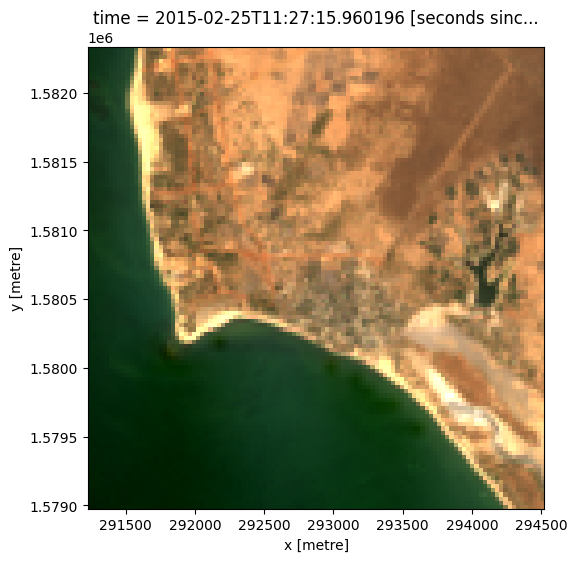

In [9]:
# Set the timesteps to visualise
timestep = 37

# Generate RGB plots at each timestep
rgb(landsat_ds, 
    index=timestep)


## Compute Modified Normalised Difference Water Index
To extract shoreline locations, we need to be able to seperate water from land in our study area. 
To do this, we can use our Landsat data to calculate a water index called the `Modified Normalised Difference Water Index`, or MNDWI. 
This index uses the ratio of green and mid-infrared radiation to identify the presence of water [(Xu 2006)](https://doi.org/10.1080/01431160600589179). 
The formula is:

$$
\begin{aligned}
\text{MNDWI} &= \frac{(\text{Green} - \text{MIR})}{(\text{Green} + \text{MIR})}
\end{aligned}
$$

where `Green` is the green band and `MIR` is the mid-infrared band. 
For Landsat, we can use the Short-wave Infrared (SWIR) 1 band as our measure for `MIR`.

When it comes to interpreting the index, **High values (greater than 0, blue colours) typically represent water pixels**, while **low values (less than 0, red colours) represent land**. 
You can use the cell below to calculate and plot one of the images after calculating the index.

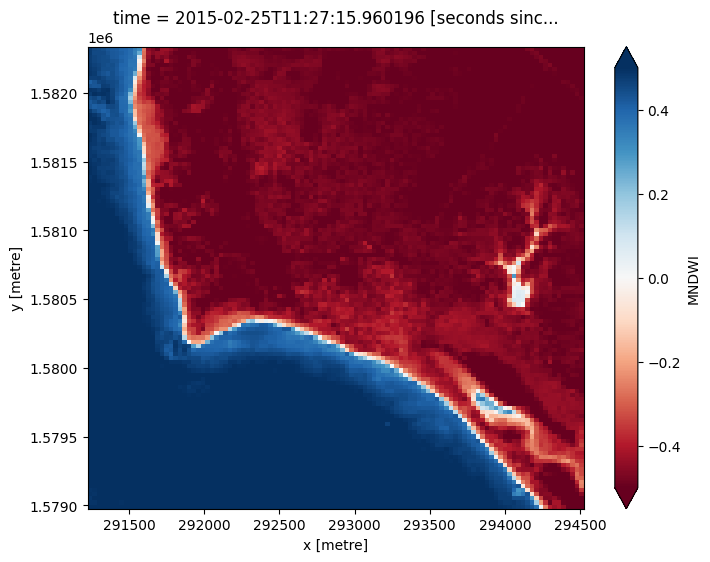

In [10]:
# Calculate the water index
landsat_ds = calculate_indices(landsat_ds, index='MNDWI', satellite_mission='ls')

# Plot the resulting image for the same timestep selected above
landsat_ds.MNDWI.isel(time=timestep).plot(cmap='RdBu',
                                          size=6,
                                          vmin=-0.5,
                                          vmax=0.5)
plt.show()


How does the plot of the index compare to the optical image from earlier? Was there water or land anywhere you weren't expecting?

## Model tide heights
The location of the shoreline can vary greatly from low to high tide. 
In the code below, we aim to reduce the effect of tides by keeping only the satellite images that were taken at specific tidal conditions. 
For example, if `tide_range = (0.25, 0.75)`, we are telling the analysis to keep only satellite images acquired at greater than the lowest 25th percentile of tide height, and less than the 75th percentile of tide height. 
This will reduce variability caused by satellite images acquired during high and low tide conditions.

The `tidal_tag` function below uses the [OTPS TPXO8 tidal model](https://www.tpxo.net/global/tpxo8-atlas) to calculate the height of the tide at the exact moment each satellite image in our dataset was taken, and adds this as a new `tide_height` attribute in our dataset. 

> **Important note:** this function can only model tides correctly if the centre of your study area is located over water. If this isn't the case, you can specify a custom tide modelling location by passing a coordinate to `tidepost_lat` and `tidepost_lon` (e.g. `tidepost_lat=14.283, tidepost_lon=-16.921`).

In [11]:
# Calculate tides for each timestep in the satellite dataset
landsat_ds = tidal_tag(ds=landsat_ds, tidepost_lat=None, tidepost_lon=None)

# Print the output dataset with new `tide_height` variable
print(landsat_ds)


Setting tide modelling location from dataset centroid: -16.92, 14.29
<xarray.Dataset>
Dimensions:      (time: 192, y: 112, x: 110)
Coordinates:
  * time         (time) datetime64[ns] 2013-03-26T11:26:35.081094 ... 2021-12...
  * y            (y) float64 1.582e+06 1.582e+06 ... 1.579e+06 1.579e+06
  * x            (x) float64 2.912e+05 2.913e+05 ... 2.945e+05 2.945e+05
    spatial_ref  int32 32628
Data variables:
    red          (time, y, x) float32 dask.array<chunksize=(1, 112, 110), meta=np.ndarray>
    green        (time, y, x) float32 dask.array<chunksize=(1, 112, 110), meta=np.ndarray>
    blue         (time, y, x) float32 dask.array<chunksize=(1, 112, 110), meta=np.ndarray>
    swir_1       (time, y, x) float32 dask.array<chunksize=(1, 112, 110), meta=np.ndarray>
    MNDWI        (time, y, x) float32 dask.array<chunksize=(1, 112, 110), meta=np.ndarray>
    tide_height  (time) float64 0.007 -0.157 0.536 0.579 ... 0.033 -0.028 0.067
Attributes:
    crs:           epsg:32628
    gri

Now that we have modelled tide heights, we can plot them to visualise the range of tide that was captured by Landsat across our time series. 
In the plot below, the grey box shows the subset of the tidal range we selected using the `tide_range` parameter. 
The plot should make it clear that limiting the range of the tides for the analysis should give you more consistent results. 
A large variance in the tide height could obscure your results, so consistency is critical as you want to compare the change in the shoreline from year to year.

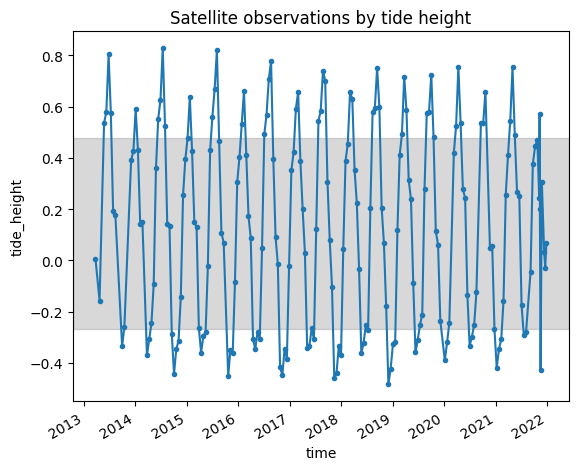

In [12]:
# Calculate the min and max tide heights to include based on the % range
min_tide, max_tide = landsat_ds.tide_height.quantile(tide_range) 

# Plot the resulting tide heights for each Landsat image:
landsat_ds.tide_height.plot(marker="o", markersize=3)
plt.axhspan(min_tide, max_tide, color='grey', alpha=0.3)
plt.title('Satellite observations by tide height')
plt.show()


### Filter Landsat images by tide height
Here we take the Landsat dataset and only keep the images with tide heights we want to analyse (i.e. tides within the heights given by `tide_range`). This will result in a smaller number of images (e.g. ~100 images compared to ~190):

In [13]:
# Keep timesteps larger than the min tide, and smaller than the max tide
landsat_filtered = landsat_ds.sel(time=(landsat_ds.tide_height > min_tide) &
                                       (landsat_ds.tide_height <= max_tide))
print(landsat_filtered)

<xarray.Dataset>
Dimensions:      (time: 96, y: 112, x: 110)
Coordinates:
  * time         (time) datetime64[ns] 2013-03-26T11:26:35.081094 ... 2021-12...
  * y            (y) float64 1.582e+06 1.582e+06 ... 1.579e+06 1.579e+06
  * x            (x) float64 2.912e+05 2.913e+05 ... 2.945e+05 2.945e+05
    spatial_ref  int32 32628
Data variables:
    red          (time, y, x) float32 dask.array<chunksize=(1, 112, 110), meta=np.ndarray>
    green        (time, y, x) float32 dask.array<chunksize=(1, 112, 110), meta=np.ndarray>
    blue         (time, y, x) float32 dask.array<chunksize=(1, 112, 110), meta=np.ndarray>
    swir_1       (time, y, x) float32 dask.array<chunksize=(1, 112, 110), meta=np.ndarray>
    MNDWI        (time, y, x) float32 dask.array<chunksize=(1, 112, 110), meta=np.ndarray>
    tide_height  (time) float64 0.007 -0.157 0.194 0.178 ... 0.033 -0.028 0.067
Attributes:
    crs:           epsg:32628
    grid_mapping:  spatial_ref


## Combine observations into noise-free summary images
Individual remote sensing images can be affected by noisy data, including clouds, sunglint and poor water quality conditions (e.g. sediment). To produce cleaner images that can be compared more easily across time, we can create 'summary' images or composites that combine multiple images into one image to reveal the median or 'typical' appearance of the landscape for a certain time period. In this case, we use the median as the summary statistic because it prevents strong outliers (like clouds that were not correctly identified by the cloud mask) from skewing the data, which would not be the case if we were to use the mean.

In the code below, we take the time series of images and combine them into single images for each `time_step`. For example, if `time_step = '2Y'`, the code will produce one new image for each two-year period in the dataset. This step can take **several minutes to load** if the study area is large.

>**Note**: We recommend opening the Dask processing window to view the different computations that are being executed; to do this, see the *Dask dashboard in DE Africa* section of the [Dask notebook](../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

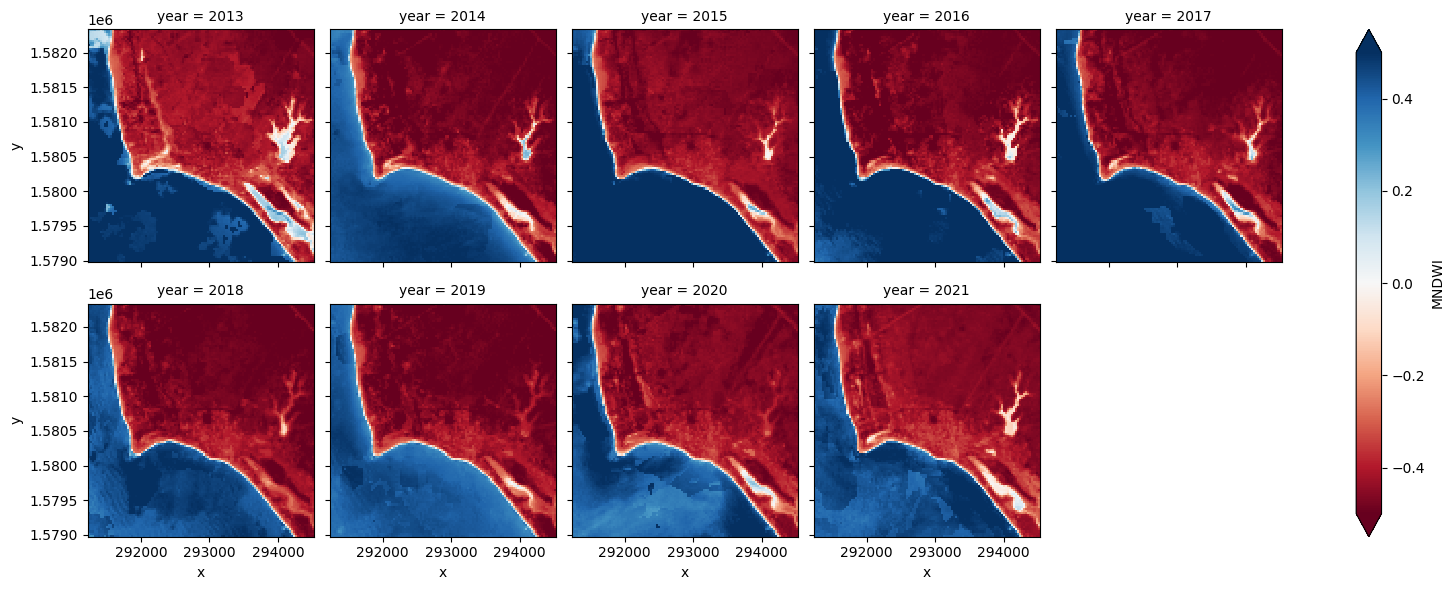

In [14]:
# Combine into summary images by `time_step`
landsat_summaries = (landsat_filtered[['MNDWI']]
                     .resample(time=time_step)
                     .median('time')
                     .compute()
                    )

# Shut down Dask client now that we have processed the data we need
client.close()

# Rename each image by year
landsat_summaries['time'] = landsat_summaries.time.dt.year
landsat_summaries = landsat_summaries.rename(time='year')

# Plot the output summary images
landsat_summaries.MNDWI.plot(col='year',
                       cmap='RdBu',
                       col_wrap=5,
                       vmin=-0.5,
                       vmax=0.5)
plt.show()


## Extract shorelines from imagery
We now want to extract an accurate shoreline for each each of the summary images above (e.g. 2014, 2015 etc. summaries). 
The code below identifies the boundary between land and water by tracing a line along pixels with a water index value of `0` (halfway between land and water water index values). 
It returns a vector file with one line for each time step:


In [15]:
# Extract waterline contours for the '0' water index threshold:
contour_gdf = subpixel_contours(da=landsat_summaries.MNDWI,
                                z_values=0,
                                dim='year',
                                crs=landsat_ds.geobox.crs,
                                affine=landsat_ds.geobox.transform,
                                output_path=f'annual_shorelines.geojson',
                                min_vertices=50).set_index('year')

# Preview shoreline data
contour_gdf

,geometry
year,
2013,"MULTILINESTRING ((291586.248 1582320.000, 2915..."
2014,"MULTILINESTRING ((291584.399 1582320.000, 2915..."
2015,"MULTILINESTRING ((291588.273 1582320.000, 2915..."
2016,"MULTILINESTRING ((291588.886 1582320.000, 2915..."
2017,"MULTILINESTRING ((291589.677 1582320.000, 2915..."
2018,"MULTILINESTRING ((291588.737 1582320.000, 2915..."
2019,"MULTILINESTRING ((291586.710 1582320.000, 2915..."
2020,"MULTILINESTRING ((291585.789 1582320.000, 2915..."
2021,"MULTILINESTRING ((291590.279 1582320.000, 2915..."


### Plot annual shorelines on an interactive map
The next cell provides an interactive map with an overlay of the shorelines identified in the previous cell. Run it to view the map (this step can take **several minutes to load** if the study area is large).

Zoom in to the map below to explore the resulting set of shorelines. 
Older shorelines are coloured in black, and more recent shorelines in yellow.
Hover over the lines to see the time period for each shoreline printed above the map.
Using this data, we can easily identify areas of coastline or rivers that have changed significantly over time, or areas that have remained stable over the entire time period. 


In [16]:
# Plot shorelines on interactive map
contour_gdf.reset_index().explore(
    column='year',
    cmap='inferno',
    tiles=
    'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='ESRI WorldImagery')

## Calculate rates of coastal change
To identify parts of the coastline that are changing rapidly, we can use our annual shoreline data to calculate rates of coastal change in metres per year.
This can be particularly useful to reveal hotspots of coastal retreat (e.g. erosion), or hotspots of coastal growth.

To do this, we first need to create a set of evenly spaced points at every 30 metres along the most recent shoreline in our dataset. 
These points will be used to plot rates of coastal change across our study area.

<Axes: >

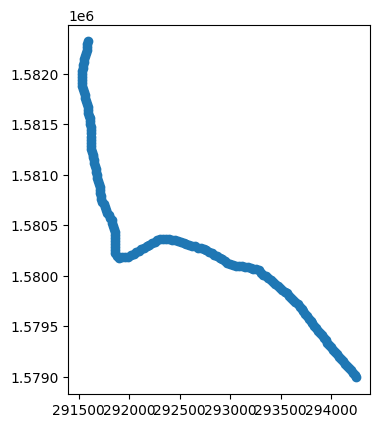

In [17]:
# Extract points at every 30 metres along the most recent shoreline
points_gdf = points_on_line(contour_gdf, index='2021', distance=30)
points_gdf.plot()

Now that we have a set of modelling points, we can measure distances from each of the points to each annual shoreline. 
This gives us a table of distances, where negative values (e.g. `-6.5`) indicate that an annual shoreline was located inland of our points, and positive values (e.g. `2.3`) indicate a shoreline was located towards the ocean. Because our points were created along our most recent 2021 shoreline, distances for 2021 will always have a distance of 0 m.

In [18]:
# For each 30 m-spaced point, calculate the distance from
# the most recent 2021 shoreline to each other annual shoreline
# in the datasets.
points_gdf = annual_movements(points_gdf,
                              contours_gdf=contour_gdf,
                              yearly_ds=landsat_summaries,
                              baseline_year=2021,
                              water_index='MNDWI')
points_gdf

,geometry,dist_2013,dist_2014,dist_2015,dist_2016,dist_2017,dist_2018,dist_2019,dist_2020,dist_2021,angle_mean,angle_std
0,POINT (291590.279 1582320.000),4.03,5.88,2.01,1.39,0.60,1.54,3.57,4.49,0.0,89,20
1,POINT (291587.167 1582290.162),1.50,5.44,0.82,1.81,1.47,2.00,2.27,5.73,0.0,96,20
2,POINT (291583.416 1582260.397),-1.10,2.61,4.27,2.58,0.23,1.58,2.78,8.99,0.0,98,21
3,POINT (291577.686 1582230.951),-2.81,1.39,3.56,-1.47,0.60,3.95,4.22,9.08,0.0,101,20
4,POINT (291569.148 1582202.198),-6.03,3.56,2.75,-4.74,4.47,1.46,5.30,4.48,0.0,105,20
...,...,...,...,...,...,...,...,...,...,...,...,...
168,POINT (294174.465 1579086.293),2.17,8.65,6.06,7.26,5.75,6.21,5.17,5.91,0.0,43,14
169,POINT (294193.384 1579063.042),0.20,7.20,7.26,6.11,4.24,4.71,5.32,3.90,0.0,44,14
170,POINT (294212.415 1579039.874),-0.99,6.44,8.60,5.82,2.66,4.83,5.00,5.59,0.0,48,16
171,POINT (294231.530 1579016.781),-1.08,6.59,9.80,5.10,1.89,4.70,4.14,5.81,0.0,47,15


Finally, we can calculate annual rates of coastal change (in metres per year) using linear regression. 
This will add several new columns to our table:

* `rate_time`: Annual rates of change (in metres per year) calculated by linearly regressing annual shoreline distances against time (excluding outliers; see `outl_time`). Negative values indicate retreat and positive values indicate growth. 
* `sig_time`: Significance (p-value) of the linear relationship between annual shoreline distances and time. Small values (e.g. p-value < 0.01 or 0.05) may indicate a coastline is undergoing consistent coastal change through time. 
* `se_time`: Standard error (in metres) of the linear relationship between annual shoreline distances and time. This can be used to generate confidence intervals around the rate of change given by rate_time (e.g. 95% confidence interval = `se_time * 1.96`)
* `outl_time`: Individual annual shoreline are noisy estimators of coastline position that can be influenced by environmental conditions (e.g. clouds, breaking waves, sea spray) or modelling issues (e.g. poor tidal modelling results or limited clear satellite observations). To obtain reliable rates of change, outlier shorelines are excluded using a robust Median Absolute Deviation outlier detection algorithm, and recorded in this column. 

In [19]:
# Calculate rates of change using linear regression
points_gdf = calculate_regressions(points_gdf=points_gdf,
                                   contours_gdf=contour_gdf)
points_gdf

,rate_time,sig_time,se_time,outl_time,dist_2013,dist_2014,dist_2015,dist_2016,dist_2017,dist_2018,dist_2019,dist_2020,dist_2021,angle_mean,angle_std,geometry
0,-0.284,0.293,0.250,,4.03,5.88,2.01,1.39,0.60,1.54,3.57,4.49,0.0,89,20,POINT (291590.279 1582320.000)
1,-0.034,0.903,0.270,,1.50,5.44,0.82,1.81,1.47,2.00,2.27,5.73,0.0,96,20,POINT (291587.167 1582290.162)
2,0.326,0.432,0.391,,-1.10,2.61,4.27,2.58,0.23,1.58,2.78,8.99,0.0,98,21,POINT (291583.416 1582260.397)
3,0.684,0.149,0.422,,-2.81,1.39,3.56,-1.47,0.60,3.95,4.22,9.08,0.0,101,20,POINT (291577.686 1582230.951)
4,0.636,0.256,0.514,,-6.03,3.56,2.75,-4.74,4.47,1.46,5.30,4.48,0.0,105,20,POINT (291569.148 1582202.198)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,-0.329,0.365,0.340,,2.17,8.65,6.06,7.26,5.75,6.21,5.17,5.91,0.0,43,14,POINT (294174.465 1579086.293)
169,-0.266,0.477,0.355,,0.20,7.20,7.26,6.11,4.24,4.71,5.32,3.90,0.0,44,14,POINT (294193.384 1579063.042)
170,-0.113,0.798,0.426,,-0.99,6.44,8.60,5.82,2.66,4.83,5.00,5.59,0.0,48,16,POINT (294212.415 1579039.874)
171,-0.162,0.736,0.463,,-1.08,6.59,9.80,5.10,1.89,4.70,4.14,5.81,0.0,47,15,POINT (294231.530 1579016.781)


### Plot rates of coastal change on an interactive map
Now that we have calculated rates of coastal change, we can plot these on an interactive map to identify parts of the coastline that are retreating or growing over time.

When the map appears below, hover your mouse over the coloured dots that appear along the coastline for a summary of recent coastal change at those locations. 
Red dots represent locations that are retreating (e.g. erosion), and blue dots represent locations that are growing.

![coastal_change.jpg](../Supplementary_data/Coastal_erosion/coastal_change.jpg)

In [20]:
# Add human-friendly label for plotting
points_gdf['Coastal change'] = points_gdf.apply(
    lambda x:
    f'<h4>This coastline has {"<b>retreated</b>" if x.rate_time < 0 else "<b>grown</b>"} '
    f'by</br><b>{x.rate_time:.2f} m (±{x.se_time:.1f}) per year</b> since '
    f'<b>{contour_gdf.index[0]}</b></h4>',
    axis=1)
points_gdf.loc[points_gdf.sig_time > 0.05, 'Coastal change'] = (
    f'<h4>No significant trend of retreat or growth)</h4>')

# Add annual shorelines to map
m = contour_gdf.reset_index().explore(
    column='year',
    cmap='inferno',
    tiles=
    'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    tooltip=False,
    style_kwds={'opacity': 0.5},
    attr='ESRI WorldImagery')

# Add rates of change to map
points_gdf.explore(
    m=m,
    column='rate_time',
    vmin=-5,
    vmax=5,
    tooltip='Coastal change',
    cmap='RdBu',
)

> **Important note:** This notebook may produce misleading rates of change for non-coastal waterbodies that might fluctuate naturally year-by-year.
The full [Digital Earth Africa Coastlines repository](https://github.com/digitalearthafrica/deafrica-coastlines.git) contains additional methods for producing more accurate rates of change by cleaning and filtering annual shoreline data to focus only on coastal shorelines.

### Export rates of change to file
Finally, we can export our output rates of change file so that it can be loaded in GIS software (e.g. ESRI ArcGIS or QGIS).

In [21]:
points_gdf.to_crs('EPSG:4326').to_file('rates_of_coastal_change.geojson')

## Drawing conclusions
Here are some questions to think about:
* What can you conclude about the change in the shoreline? 
* Which sections of the shoreline have seen the most change? 
* Is the change consistent with erosion? 
* What other information might you need to draw additional conclusions about the cause of the change?

## Next steps
When you are done, return to the "Set up analysis" cell, modify some values (e.g. `time_range`, `tide_range`, `time_step` or `lat`/`lon`) and rerun the analysis.
If you're going to change the location, you'll need to make sure Landsat data is available for the new location, which you can check at the [DE Africa Explorer](https://explorer.digitalearth.africa/products/ls8_sr) (use the drop-down menu to view all Landsat products). 

For more information about the method behind this notebook, read the scientific paper:
> Bishop-Taylor, R., Nanson, R., Sagar, S., Lymburner, L. (2021). Mapping Australia's dynamic coastline at mean sea level using three decades of Landsat imagery. Remote Sensing of Environment 267, 112734. Available: https://doi.org/10.1016/j.rse.2021.112734

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

In [22]:
print(datacube.__version__)

1.8.12


**Last Tested:**

In [23]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2023-04-05'